### WGAN with Deep Convolution

In [1]:
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
from forgebox.ftorch import FG

In [3]:
fg = FG("wgan_dc",remark="wgan and with deep convolutional model")
p = fg.p

==========hyper params==========
{'hs': 2048}


### Data Pipeline

In [4]:
train = MNIST("/data/MNIST_TORCH/", train = True, transform=transforms.Compose([transforms.ToTensor()]), download=False)
valid = MNIST("/data/MNIST_TORCH/", train = False, transform=transforms.Compose([transforms.ToTensor()]), download=False)

In [5]:
from torch import nn
import torch
from torch.utils.data import DataLoader

In [6]:
# next(iter(DataLoader(train)))

In [7]:
CUDA = torch.cuda.is_available()

In [8]:
def conv_layer(in_,out,ks=3,padding=None,bn=True, act=True):
    convs = [
        nn.Conv2d(in_,out, 
                kernel_size=3, 
                padding=ks//2 if padding== None else padding, 
                bias=False if bn else True,),
            ]
    if bn: convs.append(nn.BatchNorm2d(out,))
    if act: convs.append(nn.ReLU())
    return nn.Sequential(*convs)

class res_block(nn.Module):
    def __init__(self, in_,ks=3, hs=None, bn = True):
        super().__init__()
        in_ = in_
        hs = hs if hs else in_
        self.convs = nn.Sequential(*[
            conv_layer(in_, hs, bn = True, ),
            conv_layer(hs, in_, bn = True, ),
        ])
    
    def forward(self,x):
        return x + self.convs(x)
        
class G(nn.Module):
    def __init__(self, in_,):
        super().__init__()
        self.in_ = in_
        self.start = nn.Linear(in_,28*28)
        self.conv_blocks = nn.Sequential(*[
            conv_layer(1,32),
            res_block(32),conv_layer(32,64),
            res_block(64),conv_layer(64,32),
            conv_layer(32,1, act= False, bn = False),
        ])        
    def forward(self,x, ):
        bs = x.size()[0]
        x = self.start(x)
        x = torch.reshape(x,(bs,1,28,28))
        x = self.conv_blocks(x)
        return torch.sigmoid(x)
    
    def new_images(self, number):
        x = torch.rand(number,self.in_)
        if CUDA: x=x.cuda()
        x = self.forward(x)
        return x
    
class D(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.conv_blocks = nn.Sequential(*[
            conv_layer(1,32),res_block(32),nn.AvgPool2d((2,2)),
            conv_layer(32,64),res_block(64),nn.AvgPool2d((2,2)),
            conv_layer(64,1,act=False, bn=False),
#             nn.AdaptiveAvgPool2d((1,1))
        ])
        self.fcb=nn.Sequential(*[
            nn.Linear(49,64,bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,1,bias=False)
        ])
        
    def forward(self,x):
        x = self.conv_blocks(x)
        bs = x.size()[0]
        x = torch.reshape(x,(bs,49))
        x = self.fcb(x)
        return x

In [9]:
d = D()

In [10]:
a = torch.rand(32,1,28,28)

In [11]:
d(a).size()

torch.Size([32, 1])

In [12]:
from forgebox.ftorch.train import Trainer
from forgebox.ftorch.callbacks import stat

from torch.optim import Adam, RMSprop

In [13]:
trainer = Trainer(dataset=train, batch_size=32, print_on=5,fg=fg, callbacks=[stat])

In [14]:
g,d = G(100,),D()
if CUDA:
    g,d = g.cuda(),d.cuda()
opt_G = RMSprop(g.parameters(),lr= 5e-5)
opt_D = RMSprop(d.parameters(),lr= 5e-5)

trainer.train_G = True
@trainer.step_train
def action(*args, **kwargs):
    if kwargs["ite"] %3 ==2:
        trainer.train_G = True
    else:
        trainer.train_G = False
    opt_G.zero_grad()
    opt_D.zero_grad()
    
    real,y = args[0]
    
    bs = real.size()[0]
    z = torch.rand(bs, 100)
    
    if CUDA:
        real = real.cuda()
        z = z.cuda()
    fake = g(z)
    x = torch.cat([real,fake], dim=0)
    if trainer.train_G:
        
        loss = - d(fake).mean()
        loss.backward()
        opt_G.step()
    else:
        loss = -(d(real).mean() - d(fake).mean())
        loss.backward()
        opt_D.step()
        for p in d.parameters():
            p.data.clamp_(-1e-1, 1e-1)
    return {"loss":loss.item()}

In [15]:
trainer.train(20)

,epoch,iter,loss,timestamp
mean,0.0,937.0,-0.005046,0.023155
min,0.0,0.0,-0.134067,0.000000
max,0.0,1874.0,0.172017,43.415948


,epoch,iter,loss,timestamp
mean,1.0,937.0,-0.041717,0.023180
min,1.0,0.0,-0.191081,0.000000
max,1.0,1874.0,0.213925,43.462292


,epoch,iter,loss,timestamp
mean,2.0,937.0,-0.060294,0.023160
min,2.0,0.0,-0.219481,0.000000
max,2.0,1874.0,0.234951,43.424099


,epoch,iter,loss,timestamp
mean,3.0,937.0,-0.067909,0.023155
min,3.0,0.0,-0.230018,0.000000
max,3.0,1874.0,0.239346,43.415992


,epoch,iter,loss,timestamp
mean,4.0,937.0,-0.070747,0.023131
min,4.0,0.0,-0.239668,0.000000
max,4.0,1874.0,0.241130,43.370812


,epoch,iter,loss,timestamp
mean,5.0,937.0,-0.073075,0.023104
min,5.0,0.0,-0.245907,0.000000
max,5.0,1874.0,0.245418,43.320746


,epoch,iter,loss,timestamp
mean,6.0,937.0,-0.072278,0.023132
min,6.0,0.0,-0.242927,0.000000
max,6.0,1874.0,0.245645,43.373415


,epoch,iter,loss,timestamp
mean,7.0,937.0,-0.073080,0.023254
min,7.0,0.0,-0.244504,0.000000
max,7.0,1874.0,0.245451,43.601679


,epoch,iter,loss,timestamp
mean,8.0,937.0,-0.074007,0.023169
min,8.0,0.0,-0.246434,0.000000
max,8.0,1874.0,0.246008,43.441587


,epoch,iter,loss,timestamp
mean,9.0,937.0,-0.074242,0.023186
min,9.0,0.0,-0.245333,0.000000
max,9.0,1874.0,0.244680,43.474251


,epoch,iter,loss,timestamp
mean,10.0,937.0,-0.074152,0.023209
min,10.0,0.0,-0.245629,0.000000
max,10.0,1874.0,0.244697,43.517481


,epoch,iter,loss,timestamp
mean,11.0,937.0,-0.073656,0.023146
min,11.0,0.0,-0.250073,0.000000
max,11.0,1874.0,0.246383,43.399018


,epoch,iter,loss,timestamp
mean,12.0,937.0,-0.073985,0.023138
min,12.0,0.0,-0.246218,0.000000
max,12.0,1874.0,0.244225,43.383157


,epoch,iter,loss,timestamp
mean,13.0,937.0,-0.073903,0.023153
min,13.0,0.0,-0.249365,0.000000
max,13.0,1874.0,0.243240,43.411688


,epoch,iter,loss,timestamp
mean,14.0,937.0,-0.073985,0.023156
min,14.0,0.0,-0.250815,0.000000
max,14.0,1874.0,0.245998,43.418094


,epoch,iter,loss,timestamp
mean,15.0,937.0,-0.074370,0.023137
min,15.0,0.0,-0.252799,0.000000
max,15.0,1874.0,0.247485,43.382040


,epoch,iter,loss,timestamp
mean,16.0,937.0,-0.074129,0.023276
min,16.0,0.0,-0.245842,0.000000
max,16.0,1874.0,0.248573,43.641567


,epoch,iter,loss,timestamp
mean,17.0,937.0,-0.074101,0.023199
min,17.0,0.0,-0.248961,0.000000
max,17.0,1874.0,0.243591,43.497734


,epoch,iter,loss,timestamp
mean,18.0,937.0,-0.074430,0.023205
min,18.0,0.0,-0.246114,0.000000
max,18.0,1874.0,0.243255,43.508900


,epoch,iter,loss,timestamp
mean,19.0,937.0,-0.074143,0.023143
min,19.0,0.0,-0.245292,0.000000
max,19.0,1874.0,0.243641,43.393598


In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

In [17]:
images = g.new_images(10)
if CUDA: images = images.cpu()

In [18]:
from IPython.display import display_jpeg

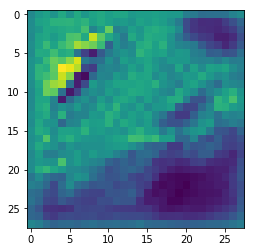

In [19]:
plt.imshow(images.data.numpy()[0][0])

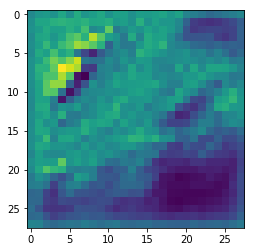

In [20]:
plt.imshow(images.data.numpy()[1][0])

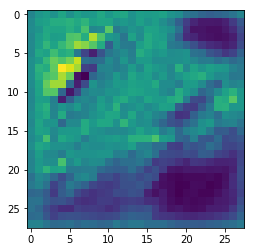

In [21]:
plt.imshow(images.data.numpy()[2][0])

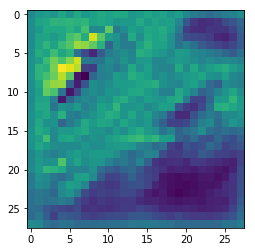

In [22]:
plt.imshow(images.data.numpy()[3][0])

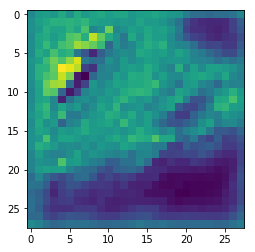

In [23]:
plt.imshow(images.data.numpy()[4][0])